# Regresia logistică multinomială
Sîrbu Matei-Dan, _grupa 10LF383_

# Load data, filtering

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List

In [239]:
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (m, n) and a column 
    vector with the m class labels in {0, ..., 9}
    """
    # scrieti cod pentru citire de CSV
    df = pd.read_csv(path, header=None)
    X = df[df.columns[1:]]
    y = df[df.columns[0]].to_frame()
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (X.shape[0], 1), 'Same number of lines is required'
    return X, y

In [240]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

In [241]:
X_train, y_train = load_file(path_train)
assert X_train.shape == (60000, 784)
assert y_train.shape == (60000, 1)

X_test, y_test = load_file(path_test)
assert X_test.shape == (10000, 784)
assert y_test.shape == (10000, 1)

In [242]:
def scale_values(X: np.ndarray) -> np.ndarray:
    """Scales the values to range [0, 1].
    :param X: an (m, n) matrix with values between 0 and 255.
    :return: an (m, n) matrix containing values of :param X: scaled in [0, 1]
    """
    # scrieti cod pentru scalare intre 0 si 1
    result = np.array(X) / 255
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'Scaled values should be in [0, 1]'
    assert X.shape == result.shape, 'Scaling preserves shape'
    return result

In [243]:
X_train = scale_values(X_train)
assert X_train.shape == (60000, 784)
X_test = scale_values(X_test)
assert X_test.shape == (10000, 784)

In [244]:
def augment_matrix(X: np.ndarray) -> np.ndarray:
    """Creates the design matrix: the original matrix with a prepended column 
    of 1.
    :param X: an (m, n) matrix. Each row contains the pixels of a digit.
    :return: an ndarray of shape (X.shape[0], X.shape[1]+1)
    """
    m = X.shape[0]
    result = np.hstack((np.ones(m).reshape(m, 1), X))
    assert result.shape == (X.shape[0], X.shape[1] + 1)
    assert np.alltrue(result[:, 0] == 1), 'The first column should be filled with 1'
    return result

In [245]:
X_train = augment_matrix(X_train)
X_test = augment_matrix(X_test)

# Create model

$$\large h_\Theta = \begin{pmatrix} P(y = 1|\textbf{x};\Theta) \\ P(y = 2|\textbf{x};\Theta) \\ . . . \\ P(y = K|\textbf{x};\Theta) \end{pmatrix} = softmax \begin{pmatrix} \theta_1^t \cdot \textbf{x} \\ \theta_2^t \cdot \textbf{x} \\ . . . \\ \theta_K^t \cdot \textbf{x} \end{pmatrix} $$<br>
$$\large \textbf{z} = (z_1, ..., z_K)^t$$ <br>
$$\large softmax(\textbf{z};l) = \frac{\exp(z_l)}{\sum_{k=1}^K \exp(z_k)}$$
<p style="text-align: center;">sau $\large softmax(\textbf{z}';l) = \frac{\exp(z_l - M)}{\sum_{k=1}^K \exp(z_k - M)}$</p>
<p style="text-align: center;">unde $k$ este numărul de clase; $ \textbf{z}' = (z_1 - M, ..., z_K - M)^t$ și $M$ valoarea maximă din $(z_1, ..., z_K)^t$ </p>

In [246]:
k = 10 # number of classes
m, n = X_train.shape # after augmentation

In [247]:
def softmax(z, axis=1):
    """Applies softmax to a matrix z.
    :param z: np.array of shape (m, k)
    :return: np.array of shape (m, k) containing in cell (i, j): P(class=j|input i)
    """
    max_z = np.max(z, axis=axis, keepdims=True) # maximum on each row
    # calcul de expnentiala; folosoti trucul dat in curs, utilizand max_z
    exp_z = np.exp(z-max_z) # all numbers exponentiated
    sum_exp_z = np.sum(np.exp(z-max_z), axis=axis, keepdims=True) # sum on each row
    # scrieti cod; se face normalizarea valorilor; considerati ultimul asert
    result = exp_z/sum_exp_z
    assert exp_z.shape == z.shape
    assert np.allclose(np.sum(result, axis=1), 1)
    return result

In [248]:
def can_multiply(a, b):
    return a.ndim == b.ndim == 2 and a.shape[1] == b.shape[0]

In [249]:
def model(X, theta):
    """
    :param X: np.array of shape (m, n)
    :param theta: np.array of shape (n, k)
    :return: np.array of shape (m, k) containing in cell (i, j): P(class=j|input i)
    """
    assert can_multiply(X, theta)
    z = X@theta
    result = softmax(z)
    return result

Funcție de cost:
$$\Large J(\Theta) = -\frac{1}{m} \Bigg[ \sum_{j=1}^m \sum_{l=1}^k I(y^{(j)} = l) \cdot \ln \frac{\exp(\theta_l^t \textbf{x}^{(j)})}{\sum_{i=1}^k\exp(\theta_i^t \textbf{x}^{(j)})} \Bigg] + \frac{\lambda}{2m} \sum_{l=1}^k \sum_{i=1}^n \theta_{li}^2$$
unde $I(\cdot)$ este funcția indicator:
$$\Large \begin{equation}
  I(valoare\_logica)= \left\{
  \begin{array}{}
    1, & \text{dacă} \ \ valoare\_logica = adevarat\\
    0, & \text{dacă} \ \ valoare\_logica = fals
  \end{array}\right.
\end{equation} 
$$

In [250]:
def J(X, y, num_classes, theta, _lambda):
    """Computes the error function for multinomial logisitc regression
    :param X: np.array of shape (m, n)
    :param y: np.array of shape (m, 1)
    :param theta: np.array of shape (n, k) 
    :return: loss values, ocmposed of cross entropy + penalty term
    """
    m = X.shape[0]
    EPS = 1e-5
    
    # computes a one hot encoding for the griven classes:
    # if y[i]=c, 0 <= c <= 9 (here), then line i in one_hot_encoding is filled
    # in with 0, excepting column c where one can find value 1
    one_hot_encoding = np.zeros((m, num_classes))
    
    # scrieti cod pentru a seta valori de 1 pe acele y[i]
    one_hot_encoding[np.arange(one_hot_encoding.shape[0]), np.transpose(y)] = 1
    
    #..... cod vectorizat
    
    assert np.all(one_hot_encoding.sum(axis=1) == 1)
    predicted = model(X, theta) # scrieti cod # shape (m, n)
    predicted = np.clip(predicted, EPS, 1-EPS) # se evita valori care duc la log(0)
    log_predicted = np.log(predicted)
    # calcul suma pentru cross entropy # Hadamard product
    temp = np.multiply(one_hot_encoding, log_predicted)
    loss1 = -temp.sum() / m # calcul valoare medie a erorii
    loss2 = _lambda/2 * (theta ** 2).sum() # calcul valoare de penalizare L2, aplicand si coeficientul _lambda
    return loss1 + loss2

Gradient:
$$\LARGE \frac{\partial J}{\partial \theta_k}(\Theta) = -\frac{1}{m}\sum_{j=1}^m \Big[  \textbf{x}^{(j)} \Big( I(y^{(j)} = k) - P(y^{(j)} = k | \textbf{x}^{(j)}; \Theta) \Big) \Big]+\frac{\lambda}{m} \theta_k$$

In [251]:
def gradient(X, theta, y, num_classes, _lambda):
    """
    :param X: np.array of shape (m, n)
    :param theta: np.array of shape (n, k)
    :param y: np.array of shape (m, 1)
    :return: np.array of shape (n, k)
    """
    
    m, n = X.shape
    # cateva linii vectorizate cu calcul de gradient
    one_hot_encoding = np.zeros((m, num_classes))
    one_hot_encoding[np.arange(one_hot_encoding.shape[0]), np.transpose(y)] = 1
    
    y_hat = model(X, theta)
    diff = np.subtract(one_hot_encoding, y_hat)
    
    grad = np.vstack([ np.sum(X * np.vstack(diff[:, k]), axis=0) for k in range(num_classes)])
    grad = grad.transpose()
    grad = 1/m * grad + (_lambda/m)*theta
    
    assert grad.shape == theta.shape
    
    return grad

In [252]:
def accuracy(X:np.array, y:np.array, theta:np.array) -> float:
    """Computes the accuracy on a given input dataset X, with ground truth y
    :param X: np.array of shape (m, n)
    :param y: np.array of shape (m, 1); each value is the index of a class
    :param theta: np.array of shape (n, k) with weights
    :return: ratio between correcly classified cases and total number of classes
    """
    # scrieti cod pentru a calcula estimarea data de model; 
    #  pe fiecare linie i si coloana c a matricei de forma (m, k) 
    #  se regaseste probabilitatea conditionata ca intrarea i sa fie de clasa c
    m = X.shape[0]
    k = theta.shape[1]
    y_hat = model(X, theta)
    # cod pentru a determina care e clase de probabilitate conditionata maxima
    threshold = 1 / k
    y_predicted = y_hat >= threshold
    one_hot_encoding = np.zeros((m, k))
    one_hot_encoding[np.arange(one_hot_encoding.shape[0]), np.transpose(y)] = 1
    y = one_hot_encoding
    return (y_predicted == y).sum() / X.shape[0]

# Train model

In [253]:
def train(X: np.array, y: np.array, num_classes, theta_init: np.array, _lambda: float, alpha: float, max_delta_error:float=1e-4) -> Tuple[np.array, List[float], List[float], List[float]]:
    """Runs the training on the training dataset (X, y). Stops when  
    difference between  two succesive error values is lower than :param max_delta_error:
    :param X: np.array of shape (m, n), with training cases. Each row is a traininv case
    :param y: np.array of shape (m, 1), containing labels (0=class 0, ...)
    :param theta_init: np.array of shape (n, k), initial weights
    :param _lambda: coefficient >= for the L2 penalty term
    :param num_classes: number of classes
    :param alpha: > 0, learning rate
    :max_delta_error: >0, a threshold for max absolute difference of succesive loss values
    :return: a tuple consisting of: weight matrix, list of errors computed at each epoch, 2 lists of accuracies on training and on test set at each epoch
    """
    theta = theta_init
    errors = [J(X, y, num_classes, theta, _lambda)]
    acc_train = [accuracy(X_train, y_train, theta)]
    acc_test = [accuracy(X_test, y_test, theta)]
    epoch = 0
    while True:
        epoch += 1
        theta += -alpha * gradient(X=X, theta=theta, y=y, num_classes=num_classes, _lambda = _lambda)
        error = J(X, y, num_classes, theta, _lambda)
        print("ERROR ", epoch, " ", error)
        errors.append(error)
        train_acc = accuracy(X_train, y_train, theta)
        acc_train.append(train_acc)
        test_acc = accuracy(X_test, y_test, theta)
        acc_test.append(test_acc)
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, error: {error}, train accuracy: {train_acc}, test accuracy: {test_acc}')
        if np.abs(errors[-1] - errors[-2]) < max_delta_error:
            break
    return theta, errors, acc_train, acc_test

In [254]:
theta = np.zeros((n, k))


theta, errors, acc_train, acc_test = train(X=X_train, y=y_train, num_classes = 10, theta_init=theta, _lambda=0.0, alpha=0.5)

ERROR  1   2.907863414957888
ERROR  2   4.183377022009991
ERROR  3   9.257255362239354
ERROR  4   10.215982818216586
ERROR  5   10.219256117097297
ERROR  6   10.219257530562025


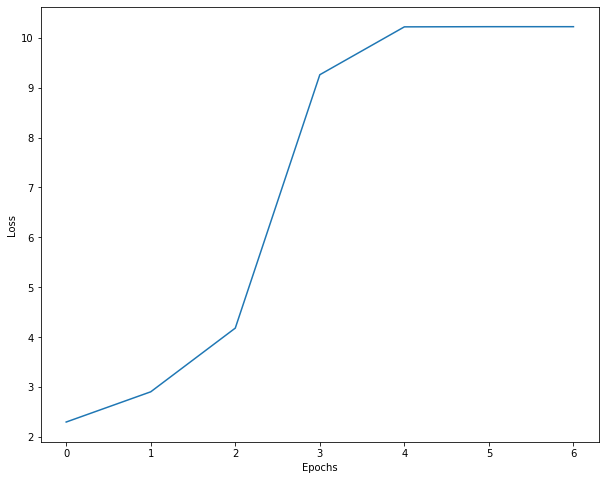

In [220]:
plt.figure(figsize=(10, 8))
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Test model

In [ ]:
# tipariti eroarea pe setul de testare